# 1. <a id='toc1_'></a>[RIPV Plotting](#toc0_)

In [1]:
import numpy as np
from scipy import integrate, linalg
import qutip as q
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import cm
import pickle
import colorcet as cc

from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.transforms import Bbox
from typing import Union
from mpl_toolkits.mplot3d.axes3d import Axes3D

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = "stix"

In [2]:
from importlib import reload
import RIPV_control_models
reload(RIPV_control_models)

<module 'RIPV_control_models' from 'c:\\Users\\neohu\\Workspaces\\quantum-space\\LandscapeCodes\\RobustnessLandscape\\Neo_RobustnessLandscape\\SinceSep27\\RIPV_control_models.py'>

In [3]:
from RIPV_control_models import *
from RIPV_core import *
from RIPV_import import *
from RIPV_pulseModel import *

**Table of contents**<a id='toc0_'></a>    
- 1. [RIPV Plotting](#toc1_)    
  - 1.1. [Comparable non-robust pulse](#toc1_1_)    
    - 1.1.1. [Rx(π) with half sine](#toc1_1_1_)    
    - 1.1.2. [iSWAP](#toc1_1_2_)    
  - 1.2. [Single noise data](#toc1_2_)    
    - 1.2.1. [R1 fixed](#toc1_2_1_)    
      - 1.2.1.1. [Error curves](#toc1_2_1_1_)    
      - 1.2.1.2. [Pulses](#toc1_2_1_2_)    
      - 1.2.1.3. [Noisefid](#toc1_2_1_3_)    
    - 1.2.2. [R1R2 fixed](#toc1_2_2_)    
      - 1.2.2.1. [Error curves](#toc1_2_2_1_)    
      - 1.2.2.2. [Pulses](#toc1_2_2_2_)    
      - 1.2.2.3. [Noisefid](#toc1_2_2_3_)    
      - 1.2.2.4. [iSWAP noisefid](#toc1_2_2_4_)    
  - 1.3. [3 Noise data](#toc1_3_)    
      - 1.3.1.1. [Rxyz θyz Δθ](#toc1_3_1_1_)    
      - 1.3.1.2. [Pulses](#toc1_3_1_2_)    
      - 1.3.1.3. [Noisefid xyz](#toc1_3_1_3_)    
  - 1.4. [Orthogonality test](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[Comparable non-robust pulse](#toc0_)

In [93]:
result_folder = 'baseSine'

### 1.1.1. <a id='toc1_1_1_'></a>[Rx(π) with half sine](#toc0_)

6.283185307179586


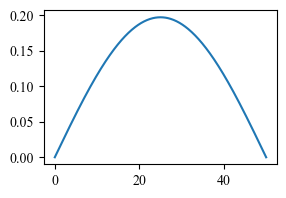

In [7]:
T = 50
t = np.linspace(0, 50, 501)
theta = 2 * np.pi  # θ for Rx(θ)
basePulse = np.sin(np.pi * t / T)
basePulse = basePulse / integrate.simpson(basePulse, x=t) * theta

print(integrate.simpson(basePulse, x=t))

plt.plot(t, basePulse)
plt.show()

In [ ]:
controlModel = SingleControlModel(
    tlist=tf.constant(np.linspace(0, 50, 501), dtype=tf.complex128),
    H_sys=0,
    H_c_terms=tf.constant([q.sigmax().full(),]),
    H_n=tf.constant(q.sigmaz().full()),
    paramsToSinglePulse=lambda A: tf.constant(basePulse, dtype=tf.complex128),
)
angleR1R2 = controlModel.angleAndR1R2(None)

In [31]:
from IPython.display import display_markdown

display_markdown(rf'$S^1 = {float(np.real(angleR1R2["cons"][0]))}$', raw=True)
display_markdown(rf'$S^2 = {float(np.real(angleR1R2["cons"][1]))}$', raw=True)

$S^1 = 21.433235472683684$

$S^2 = 127.77750338079133$

In [16]:
# Stolen from file `RIPV-Autodiff-Experiment.ipynb`
def XcZn_deltaPercentVsFidelity(pulse, tlist,  progressBar=True):
    pulse = np.array(pulse).real
    maxAmp = np.max(np.abs(pulse))

    theta = integrate.simpson(pulse, x=tlist)
    gateIdeal = (-1j * q.sigmax() * theta/2).expm().full()

    deltaPercentList = np.linspace(-.2, .2, 101)
    fidelityList = []
    if progressBar:
        from tqdm import tqdm
    else:
        tqdm = lambda x: x
    for deltaPercent in tqdm(deltaPercentList):
        delta = deltaPercent * maxAmp
        H = q.QobjEvo([
            delta / 2 * q.sigmaz(),
            [q.sigmax(), pulse / 2]
        ], tlist=tlist)
        Ulist = q.propagator(H, tlist)
        fidelityList.append(matrix_similarity(Ulist[-1], gateIdeal))
    return deltaPercentList, np.array(fidelityList)


In [ ]:
noiseFid = XcZn_deltaPercentVsFidelity(basePulse, t)
np.save(f'./data/{result_folder}/noiseFid.npy', noiseFid)

100%|██████████| 101/101 [00:02<00:00, 47.93it/s]


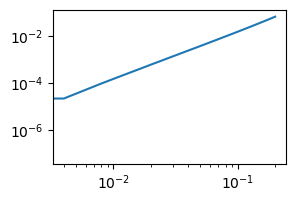

In [20]:
noise, fid = noiseFid
infid = 1 - fid
plt.loglog(noise, infid)
plt.show()

### 1.1.2. <a id='toc1_1_2_'></a>[iSWAP](#toc0_)

In [98]:
# Stolen from file `RIPV-Autodiff-Experiment.ipynb`
def plot_iSWAPfid_detuningNoise(pulse, tlist, progressBar=True):
    pulse = np.array(pulse).real
    maxAmp = np.max(np.abs(pulse))

    X, Y, Z, I = q.sigmax(), q.sigmay(), q.sigmaz(), q.identity(2)
    XX_plus_YY = (q.tensor([X, X]) + q.tensor([Y, Y]))
    ZI_minus_IZ = (q.tensor([Z, I]) - q.tensor([I, Z]))# * 1/2
    # XX_plus_YY = X
    # ZI_minus_IZ = Z

    thetaIdeal = integrate.simpson(pulse, x=tlist)
    gateIdeal = (-1j * XX_plus_YY * thetaIdeal/4).expm().full()

    deltaPercentList = np.linspace(-.2, .2, 101)
    fidelityList = []
    if progressBar:
        from tqdm import tqdm
    else:
        tqdm = lambda x: x
    for deltaPercent in tqdm(deltaPercentList):
        delta = deltaPercent * maxAmp
        H = q.QobjEvo([
            delta / 4 * ZI_minus_IZ,  # noise
            [XX_plus_YY, pulse / 4],  # drive
        ], tlist=tlist)
        Ulist = q.propagator(H, tlist)
        # print(Ulist[-1], gateIdeal, sep='\n', end='\n\n')
        # correction = (-1j * -delta / 2 * ZI * tlist[-1]).expm().full()
        fidelityList.append(matrix_similarity(Ulist[-1], gateIdeal))
    return deltaPercentList, np.real(fidelityList)


noiseFid_iSWAP = plot_iSWAPfid_detuningNoise(basePulse, t)
np.save(f'./data/{result_folder}/noiseFid_iSWAP.npy', noiseFid_iSWAP)

100%|██████████| 101/101 [00:02<00:00, 47.16it/s]


## 1.2. <a id='toc1_2_'></a>[Single noise data](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[R1 fixed](#toc0_)

In [32]:
result_folder = 'fromHai_R1fixed'

In [33]:
with open(f'data/{result_folder}/result.pickle', mode='rb') as f:
    result = pickle.load(f)

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


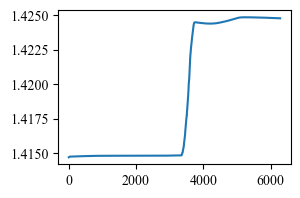

In [34]:
plt.plot(result['cons'])

#### 1.2.1.1. <a id='toc1_2_1_1_'></a>[Error curves](#toc0_)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3313939419.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3313939419.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3313939419.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


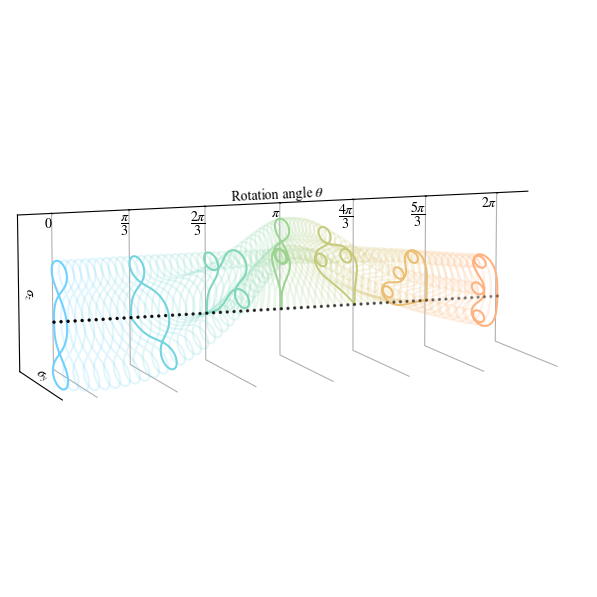

In [89]:
def plotCurves_Xcontrol_R1(result, fig: Union[Figure, SubFigure], cmap=cm.brg):
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    curvexyz_list = result['curvexyz']
    LENGTH = len(curvexyz_list)
    numOfParams = 9

    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

    highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))
    ALLONE = np.ones(curvexyz_list[0][1].shape)
    angle_x_list = []
    for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
        _, curve_y, curve_z = curvexyz_list[index]
        curve_y, curve_z = np.array(curve_y).real, np.array(curve_z).real
        angle_x = np.real(result['cost'][index]) - (2*np.pi)
        ax.plot(
            ALLONE * angle_x, curve_y, curve_z,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
        angle_x_list.append(angle_x)
    ax.scatter(angle_x_list, 0, 0, color='black', s=2)
    
    ax.set_box_aspect((3.5, 1, 1))
    ax.view_init(9, -110, 0)

    ax.set_xlabel('Rotation angle ' + r'$\theta$',
                  labelpad=-10)
    ax.xaxis._axinfo['juggled'] = (2,0,1)
    PI = np.pi
    xticks = [0, PI/3, 2*PI/3, 3*PI/3, 4*PI/3, 5*PI/3, 2*PI]
    xtickLabels = [
        s+'\n\n' for s in
        r'$0$ $\dfrac{\pi}{3}$ $\dfrac{2\pi}{3}$ $\pi$ $\dfrac{4\pi}{3}$ $\dfrac{5\pi}{3}$ $2\pi$'.split()
    ]
    ax.set_xticks(xticks, xtickLabels, ha='right')
    ax.tick_params(axis="x", pad=-12)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.set_ylabel(r'$\sigma_y$       ', labelpad=-25)
    yticks = []
    ax.set_yticks(yticks)
    # ax.tick_params(axis="y", pad=-2)
    ax.set_ylim(-20, 0)
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_zlabel(r'$\sigma_z$', labelpad=-25)
    zticks = []
    ax.set_zticks(zticks)
    ax.set_zlim(-15, 35)
    # ax.zaxis.set_tick_params(labelright=True)
    # ax.zaxis.set_tick_params(va='center')
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return

%matplotlib inline
from matplotlib.transforms import Bbox


fig = plt.figure(figsize=(15, 7.5), layout='constrained')

cmap = cc.cm.CET_I2
plotCurves_Xcontrol_R1(result, fig, cmap=cmap)
# fig.set_layout_engine('tight')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
fig.savefig(rf".\data\{result_folder}\_error_curves_contichange.pdf",
            bbox_inches=Bbox([[4.7, 2.6],  # L, B
                              [10.1, 4.9]]))  # R, T
fig.show()

#### 1.2.1.2. <a id='toc1_2_1_2_'></a>[Pulses](#toc0_)

In [90]:
hai = HaiPulse(result['tlist'])
integrate.simpson(hai.fromParams(result['x'][50]), x=result['tlist'])

(6.336446572903972+0j)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\173849226.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\173849226.py:68: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\173849226.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


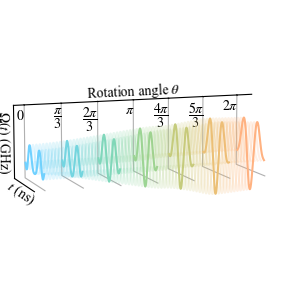

In [91]:
def plotCurves_Xcontrol_R1(result, fig: Union[Figure, SubFigure], cmap=cm.brg):
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    tlist = np.array(result['tlist']).real
    LENGTH = len(result['x'])
    numOfParams = 9
    hai = HaiPulse(tlist)

    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

    highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))
    ALLONE = np.ones(tlist.shape)
    for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
        A = result['x'][index]
        pulse = np.array(hai.fromParams(A)).real
        angle_x = np.real(result['cost'][index]) - (2*np.pi)
        ax.plot(
            ALLONE * angle_x, -tlist, pulse,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
    
    ax.set_box_aspect((3.5, 1, 1))
    ax.view_init(9, -110, 0)

    ax.set_xlabel('Rotation angle ' + r'$\theta$',
                  labelpad=-10)
    ax.xaxis._axinfo['juggled'] = (2,0,1)
    PI = np.pi
    xticks = [0, PI/3, 2*PI/3, 3*PI/3, 4*PI/3, 5*PI/3, 2*PI]
    xtickLabels = [
        s+'\n\n' for s in
        r'$0$ $\dfrac{\pi}{3}$ $\dfrac{2\pi}{3}$ $\pi$ $\dfrac{4\pi}{3}$ $\dfrac{5\pi}{3}$ $2\pi$'.split()
    ]
    ax.set_xticks(xticks, xtickLabels, ha='right')
    ax.tick_params(axis="x", pad=-12)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlim(left=-0.05*np.pi)
    
    ax.set_ylabel(r'     $t$ (ns)', labelpad=-17)
    yticks = []
    ax.set_yticks(yticks)
    # ax.tick_params(axis="y", pad=-2)
    ax.set_ylim(-52, 0)
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_zlabel(r'$\Omega(t)$ (GHz)', labelpad=-17)
    zticks = []
    ax.set_zticks(zticks)
    ax.set_zlim(-0.4, 1.6)
    # ax.zaxis.set_tick_params(labelright=True)
    # ax.zaxis.set_tick_params(va='center')
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return

%matplotlib inline
from matplotlib.transforms import Bbox


fig = plt.figure(figsize=(7.5, 3.5), layout='constrained')

cmap = cc.cm.CET_I2
plotCurves_Xcontrol_R1(result, fig, cmap=cmap)
# fig.set_layout_engine('tight')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
fig.savefig(rf".\data\{result_folder}\_pulses_contichange.png", dpi=400,
            bbox_inches=Bbox([[2.36, 1.07],  # L, B
                              [5.06, 2.39]]))  # R, T
fig.show()

#### 1.2.1.3. <a id='toc1_2_1_3_'></a>[Noisefid](#toc0_)

In [92]:
with open(rf'data\{result_folder}\noiseVSFid.pickle', mode='rb') as f:
    noiseFid_list = pickle.load(f)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\1327899695.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


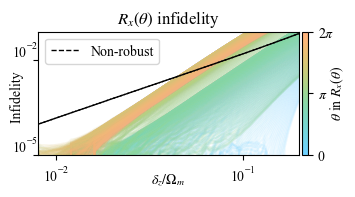

In [93]:
def plotNoiseFid_Xnoise_R1(
        noiseFid_list, fig: Union[Figure, SubFigure], _δm=0.2+1e-7, cmap=cm.brg,
        wspace=0.0, cbarPad=0.2,
    ) -> None:
    ax = fig.subplots()
    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)
    
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid_list[0][0], noiseFid_list[0][0] < _δm
    ))[0]

    # Hack from RIPV-Autodiff-Experiments: get indices of these sampled pulses
    sampleIndices = list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]

    for k in range(len(noiseFid_list)):
        fids = np.array(noiseFid_list[k][1])
        angle_x = np.real(result['cost'][sampleIndices[k]] - 2*np.pi)
        ax.loglog(
            noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )
        ax.loglog(
            - noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )

    # Plot baseline pulse: half sine
    noiseFid = np.load(f'./data/baseSine/noiseFid.npy')
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid[0], noiseFid[0] < _δm
    ))[0]
    ax.loglog(
        noiseFid[0][needToShow],
        1-noiseFid[1][needToShow],
        linestyle='dashed', color='black', linewidth=1
    )
    baseFids = ax.loglog(
        - noiseFid[0][needToShow],
        1-noiseFid[1][needToShow],
        linestyle='dashed', color='black', linewidth=1
    )
    ax.legend(baseFids, ['Non-robust'])

    ax.set_xlabel(rf'$\delta_z/\Omega_m$', labelpad=-9)
    # ax.set_ylim(bottom=1-1e-2, top=1+1e-5)
    # ax.set_ylabel('Fidelity')
    ax.set_xlim(0.008, 0.2)
    ticks = []
    # ax.set_xticks(ticks)

    ax.set_ylabel('Infidelity  ', labelpad=-9)
    ax.set_ylim(1e-5, 10**(-1.1))
    ax.set_yticks(ticks=[1e-5, 1e-2])
    ax.set_yticklabels(ax.get_yticklabels(), va='bottom')
    ax.minorticks_off()
    ax.tick_params(axis="y", pad=-3)

    ax.set_title(r'$R_x(\theta)$ infidelity')

    cbar = fig.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=ax, pad=cbarPad)
    cbar.set_label(r'$\theta$ in $R_x(\theta)$', labelpad=-4)  # Set the label for the colorbar
    cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
    cbar.set_ticklabels('0 $\pi$ $2\pi$'.split())  # Set custom tick labels

    return

cmap = cc.cm.CET_I2

fig = plt.figure(figsize=(4, 1.6))
plotNoiseFid_Xnoise_R1(noiseFid_list, fig, cmap=cmap, cbarPad=0.01)
tightBox = fig.get_tightbbox()
fig.savefig(rf".\data\{result_folder}\_noiseFid_stacked.png", bbox_inches=tightBox, dpi=500)
# seq += 1
# fig.suptitle('semilogy infid ym=1e-5', y=1)
# fig.savefig(rf"H:\Neo\Study\SUSTech Physics\Projects\RIPV\paper\temp\XYZnoiseFid_{seq}.png", bbox_inches='tight')
fig.show()

### 1.2.2. <a id='toc1_2_2_'></a>[R1R2 fixed](#toc0_)

In [38]:
result_folder = 'fromHai_R1R2fixed'

In [39]:
with open(f'data/{result_folder}/result.pickle', mode='rb') as f:
    result = pickle.load(f)

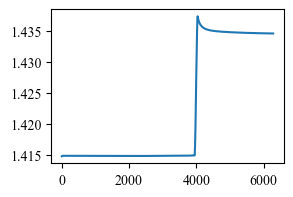

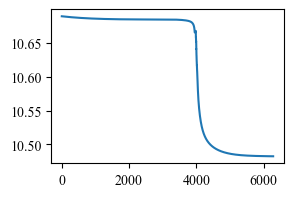

In [38]:
plt.plot(np.real(result['cons'])[:, 0])
plt.show()
plt.plot(np.real(result['cons'])[:, 1])
plt.show()

#### 1.2.2.1. <a id='toc1_2_2_1_'></a>[Error curves](#toc0_)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\1685642761.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\1685642761.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\1685642761.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


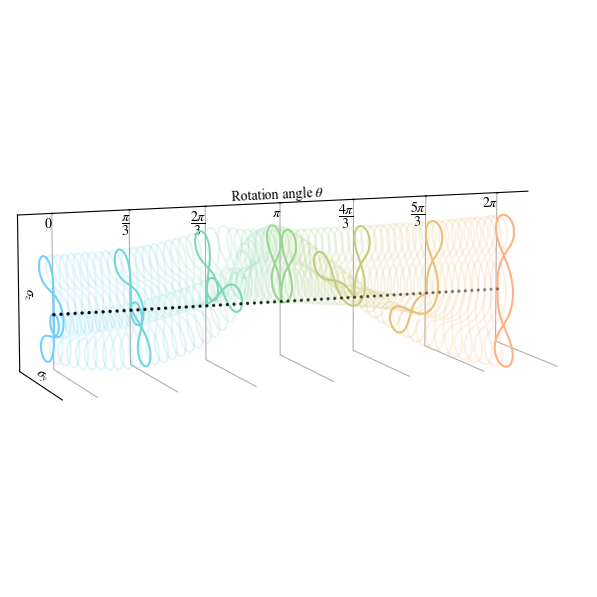

In [97]:
def plotCurves_Xcontrol_R1R2(result, fig: Union[Figure, SubFigure], cmap=cm.brg):
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    curvexyz_list = result['curvexyz']
    LENGTH = len(curvexyz_list)
    numOfParams = 9

    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

    highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))
    ALLONE = np.ones(curvexyz_list[0][1].shape)
    angle_x_list = []
    for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
        _, curve_y, curve_z = curvexyz_list[index]
        curve_y, curve_z = np.array(curve_y).real, np.array(curve_z).real
        angle_x = np.real(result['cost'][index])
        ax.plot(
            ALLONE * angle_x, curve_y, curve_z,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
        angle_x_list.append(angle_x)
    ax.scatter(angle_x_list, 0, 0, color='black', s=2)
    
    ax.set_box_aspect((3.5, 1, 1))
    ax.view_init(9, -110, 0)

    ax.set_xlabel('Rotation angle ' + r'$\theta$',
                  labelpad=-10)
    ax.xaxis._axinfo['juggled'] = (2,0,1)
    PI = np.pi
    xticks = [0, PI/3, 2*PI/3, 3*PI/3, 4*PI/3, 5*PI/3, 2*PI]
    xtickLabels = [
        s+'\n\n' for s in
        r'$0$ $\dfrac{\pi}{3}$ $\dfrac{2\pi}{3}$ $\pi$ $\dfrac{4\pi}{3}$ $\dfrac{5\pi}{3}$ $2\pi$'.split()
    ]
    ax.set_xticks(xticks, xtickLabels, ha='right')
    ax.tick_params(axis="x", pad=-12)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.set_ylabel(r'$\sigma_y$       ', labelpad=-25)
    yticks = []
    ax.set_yticks(yticks)
    # ax.tick_params(axis="y", pad=-2)
    ax.set_ylim(-12, 0)
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_zlabel(r'$\sigma_z$', labelpad=-25)
    zticks = []
    ax.set_zticks(zticks)
    ax.set_zlim(-7, 13)
    # ax.zaxis.set_tick_params(labelright=True)
    # ax.zaxis.set_tick_params(va='center')
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return

%matplotlib inline
from matplotlib.transforms import Bbox


fig = plt.figure(figsize=(15, 7.5), layout='constrained')

cmap = cc.cm.CET_I2
plotCurves_Xcontrol_R1R2(result, fig, cmap=cmap)
# fig.set_layout_engine('tight')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
fig.savefig(rf".\data\{result_folder}\_error_curves_contichange.pdf",
            bbox_inches=Bbox([[4.7, 2.6],  # L, B
                              [10.1, 4.9]]))  # R, T
fig.show()

#### 1.2.2.2. <a id='toc1_2_2_2_'></a>[Pulses](#toc0_)

In [98]:
hai = HaiPulse(result['tlist'])
integrate.simpson(hai.fromParams(result['x'][50]), x=result['tlist'])

(6.236445838474507+0j)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\762320767.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\762320767.py:68: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\762320767.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


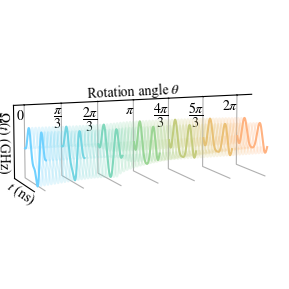

In [99]:
def plotCurves_Xcontrol_R1R2(result, fig: Union[Figure, SubFigure], cmap=cm.brg):
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    tlist = np.array(result['tlist']).real
    LENGTH = len(result['x'])
    numOfParams = 9
    hai = HaiPulse(tlist)

    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

    highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))
    ALLONE = np.ones(tlist.shape)
    for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
        A = result['x'][index]
        pulse = np.array(hai.fromParams(A)).real
        angle_x = np.real(result['cost'][index])
        ax.plot(
            ALLONE * angle_x, -tlist, pulse,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
    
    ax.set_box_aspect((3.5, 1, 1))
    ax.view_init(9, -110, 0)

    ax.set_xlabel('Rotation angle ' + r'$\theta$',
                  labelpad=-10)
    ax.xaxis._axinfo['juggled'] = (2,0,1)
    PI = np.pi
    xticks = [0, PI/3, 2*PI/3, 3*PI/3, 4*PI/3, 5*PI/3, 2*PI]
    xtickLabels = [
        s+'\n\n' for s in
        r'$0$ $\dfrac{\pi}{3}$ $\dfrac{2\pi}{3}$ $\pi$ $\dfrac{4\pi}{3}$ $\dfrac{5\pi}{3}$ $2\pi$'.split()
    ]
    ax.set_xticks(xticks, xtickLabels, ha='right')
    ax.tick_params(axis="x", pad=-12)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlim(left=-0.05*np.pi)
    
    ax.set_ylabel(r'     $t$ (ns)', labelpad=-17)
    yticks = []
    ax.set_yticks(yticks)
    # ax.tick_params(axis="y", pad=-2)
    ax.set_ylim(-47, 0)
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_zlabel(r'$\Omega(t)$ (GHz)', labelpad=-17)
    zticks = []
    ax.set_zticks(zticks)
    ax.set_zlim(-0.75, 1.1)
    # ax.zaxis.set_tick_params(labelright=True)
    # ax.zaxis.set_tick_params(va='center')
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return

%matplotlib inline
from matplotlib.transforms import Bbox


fig = plt.figure(figsize=(7.5, 3.5), layout='constrained')

cmap = cc.cm.CET_I2
plotCurves_Xcontrol_R1R2(result, fig, cmap=cmap)
# fig.set_layout_engine('tight')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
fig.savefig(rf".\data\{result_folder}\_pulses_contichange.png", dpi=400,
            bbox_inches=Bbox([[2.36, 1.07],  # L, B
                              [5.08, 2.39]]))  # R, T
fig.show()

#### 1.2.2.3. <a id='toc1_2_2_3_'></a>[Noisefid](#toc0_)

In [40]:
with open(rf'data\{result_folder}\noiseVSFid.pickle', mode='rb') as f:
    noiseFid_list = pickle.load(f)

In [44]:
dl, dr = [], []
for delta, fid in noiseFid_list:
    fid = np.array(fid)
    idx = np.argmax(fid >= 0.999)
    dl.append(delta[idx])
    idx = len(delta) - 1 - np.argmax(fid[::-1] >= 0.999)
    dr.append(delta[idx])
np.max(dl), np.min(dr)

(-0.10800000000000001, 0.10799999999999998)

C:\Users\neohu\AppData\Local\Temp\ipykernel_46120\3729167599.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


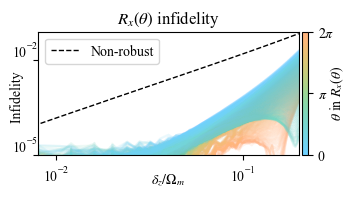

In [53]:
def plotNoiseFid_Xnoise_R1R2(
        noiseFid_list, fig: Union[Figure, SubFigure], _δm=0.2+1e-7, cmap=cm.brg,
        wspace=0.0, cbarPad=0.2,
    ) -> None:
    ax = fig.subplots()
    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)
    
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid_list[0][0], noiseFid_list[0][0] < _δm
    ))[0]

    # Hack from RIPV-Autodiff-Experiments: get indices of these sampled pulses
    sampleIndices = list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]

    for k in range(len(noiseFid_list)):
        fids = np.array(noiseFid_list[k][1])
        angle_x = np.real(result['cost'][sampleIndices[k]])
        ax.loglog(
            noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )
        ax.loglog(
            - noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )

    # Plot baseline pulse: half sine
    noiseFid = np.load(f'./data/baseSine/noiseFid.npy')
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid[0], noiseFid[0] < _δm
    ))[0]
    baseFids = ax.loglog(
        noiseFid[0][needToShow],
        1-noiseFid[1][needToShow],
        linestyle='dashed', color='black', linewidth=1
    )
    # # Same as positive noise
    # ax.loglog(
    #     - noiseFid[0][needToShow],
    #     1-noiseFid[1][needToShow],
    #     linestyle='dashed', color='black', linewidth=1
    # )
    ax.legend(baseFids, ['Non-robust'])
    
    ax.set_xlabel(rf'$\delta_z/\Omega_m$', labelpad=-9)
    # ax.set_ylim(bottom=1-1e-2, top=1+1e-5)
    # ax.set_ylabel('Fidelity')
    ax.set_xlim(0.008, 0.2)
    ticks = []
    # ax.set_xticks(ticks)

    ax.set_ylabel('Infidelity  ', labelpad=-9)
    ax.set_ylim(1e-5, 10**(-1.1))
    ax.set_yticks(ticks=[1e-5, 1e-2])
    ax.set_yticklabels(ax.get_yticklabels(), va='bottom')
    ax.minorticks_off()
    ax.tick_params(axis="y", pad=-3)

    ax.set_title(r'$R_x(\theta)$ infidelity')

    cbar = fig.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=ax, pad=cbarPad)
    cbar.set_label(r'$\theta$ in $R_x(\theta)$', labelpad=-4)  # Set the label for the colorbar
    cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
    cbar.set_ticklabels('0 $\pi$ $2\pi$'.split())  # Set custom tick labels

    return

cmap = cc.cm.CET_I2

fig = plt.figure(figsize=(4, 1.6))
plotNoiseFid_Xnoise_R1R2(noiseFid_list, fig, cmap=cmap, cbarPad=0.01)
tightBox = fig.get_tightbbox()
fig.savefig(rf".\data\{result_folder}\_noiseFid_stacked.png", bbox_inches=tightBox, dpi=500)
# seq += 1
# fig.suptitle('semilogy infid ym=1e-5', y=1)
# fig.savefig(rf"H:\Neo\Study\SUSTech Physics\Projects\RIPV\paper\temp\XYZnoiseFid_{seq}.png", bbox_inches='tight')
fig.show()

#### 1.2.2.4. <a id='toc1_2_2_4_'></a>[iSWAP noisefid](#toc0_)

In [102]:
with open(rf'data\{result_folder}\noiseVSFid_iSWAP.pickle', mode='rb') as f:
    noiseFid_list = pickle.load(f)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\605114800.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


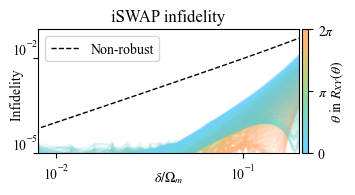

In [103]:
def plotNoiseFid_Xnoise_R1R2iSWAP(
        noiseFid_list, fig: Union[Figure, SubFigure], _δm=0.2+1e-7, cmap=cm.brg,
        wspace=0.0, cbarPad=0.2,
    ) -> None:
    ax = fig.subplots()
    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)
    
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid_list[0][0], noiseFid_list[0][0] < _δm
    ))[0]

    # Hack from RIPV-Autodiff-Experiments: get indices of these sampled pulses
    sampleIndices = list(range(0, len(result['x']), 10)) + [len(result['x'])-1,]

    for k in range(len(noiseFid_list)):
        fids = np.array(noiseFid_list[k][1])
        angle_x = np.real(result['cost'][sampleIndices[k]])
        ax.loglog(
            noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )
        ax.loglog(
            - noiseFid_list[k][0][needToShow],
            1-fids[needToShow],
            c=cmap(colorNormalizer(angle_x)),
            alpha=.07
        )

    # Plot baseline pulse: half sine
    noiseFid = np.load(f'./data/baseSine/noiseFid_iSWAP.npy')
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid[0], noiseFid[0] < _δm
    ))[0]
    baseFids = ax.loglog(
        noiseFid[0][needToShow],
        1-noiseFid[1][needToShow],
        linestyle='dashed', color='black', linewidth=1
    )
    ax.legend(baseFids, ['Non-robust'])
    
    ax.set_xlabel(rf'$\delta/\Omega_m$', labelpad=-9)
    ax.set_xlim(0.008, 0.2)
    ticks = []
    # ax.set_xticks(ticks)

    ax.set_ylabel('Infidelity  ', labelpad=-9)
    ax.set_ylim(1e-5, 10**(-1.1))
    ax.set_yticks(ticks=[1e-5, 1e-2])
    ax.set_yticklabels(ax.get_yticklabels(), va='bottom')
    ax.minorticks_off()
    ax.tick_params(axis="y", pad=-3)

    ax.set_title(r'iSWAP infidelity')

    cbar = fig.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=ax, pad=cbarPad)
    cbar.set_label(r'$\theta$ in $R_{XY}(\theta)$', labelpad=-4)  # Set the label for the colorbar
    cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
    cbar.set_ticklabels('0 $\pi$ $2\pi$'.split())  # Set custom tick labels

    return

cmap = cc.cm.CET_I2

fig = plt.figure(figsize=(4, 1.6))
plotNoiseFid_Xnoise_R1R2iSWAP(noiseFid_list, fig, cmap=cmap, cbarPad=0.01)
tightBox = fig.get_tightbbox().get_points()  # [[x0, y0], [x1, y1]]
tightBox[1][1] += 0.05
tightBox = Bbox(tightBox)
fig.savefig(rf".\data\{result_folder}\_noiseFid_iSWAP_stacked.png", bbox_inches=tightBox, dpi=500)
# seq += 1
# fig.suptitle('semilogy infid ym=1e-5', y=1)
# fig.savefig(rf"H:\Neo\Study\SUSTech Physics\Projects\RIPV\paper\temp\XYZnoiseFid_{seq}.png", bbox_inches='tight')
fig.show()

## 1.3. <a id='toc1_3_'></a>[3 Noise data](#toc0_)

#### 1.3.1.1. <a id='toc1_3_1_1_'></a>[Rxyz θyz Δθ](#toc0_)

In [42]:
with open(r'.\data\XYcontrolXYZnoise\result_Neg0to2PI.pickle', mode='rb') as f:
    result_Neg0to2PI = pickle.load(f)
thetas = np.array(result_Neg0to2PI['cost'])

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


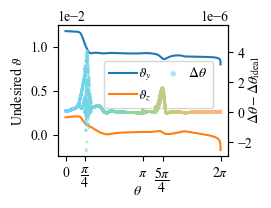

c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\axes\_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
c:\Users\neohu\.conda\envs\tf\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


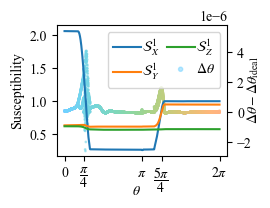

In [48]:
%matplotlib inline
# Check rotation on σy, σz
Rxyzθyz_list = result_Neg0to2PI['cons']
Rxyz_list = [Rxyzθyz[:3] for Rxyzθyz in Rxyzθyz_list]
θyz_list = [Rxyzθyz[-2:] for Rxyzθyz in Rxyzθyz_list]
commonTicks = [0, np.pi/4, 1*np.pi, 5*np.pi/4, 2*np.pi]
commonLabels = r'''
0 $\dfrac{\pi}{4}$ $\pi$ $\dfrac{5\pi}{4}$ $2\pi$'''.split()
commonFigsize = (2.2, 1.7)
theta_ideal = 5e-4

cmap = cc.cm.CET_I2

fig, ax1 = plt.subplots(figsize=commonFigsize)
ax2 = ax1.twinx()
lines: list = ax1.plot(thetas, θyz_list, label=r'$\vartheta_y$ $\vartheta_z$'.split())
every = 1
scatted = ax2.scatter(thetas[1::every], np.diff(thetas)[::every] - theta_ideal,
                      c=thetas[1::every], label=r'$\Delta\theta$', marker='o',
                      s=1, alpha=.5, cmap=cmap)
lines.append(scatted)
# lines.insert(0, scatted)
# # Empty legend for alignment
# lines.insert(1, plt.Line2D([], [], linestyle='none', marker='none'))

ax1.set_xticks(commonTicks, labels=commonLabels)
ax1.set_xlabel(r'$\theta$    ', labelpad=-8)
ax1.set_ylabel(r'Undesired $\vartheta$')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax2.set_ylabel(r'$\Delta\theta - \Delta\theta_\text{ideal}$', labelpad=-5)
ax2.set_yticks(np.array([-2, 0, 2, 4]) * 1e-6)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(ymax=0.058e-4)

ax1.legend(lines, [l.get_label() for l in lines],
           loc=0, ncol=2, markerscale=3, columnspacing=0.5, handletextpad=0.1, labelspacing=0.3,
           bbox_to_anchor=(.28, .38, .67, .4)) # (x,y,width,height)
# ax1.set_title('Undesired rotation', pad=15)
tightBox = fig.get_tightbbox()
plt.savefig(r'.\data\XYcontrolXYZnoise\theta_yz.pdf',
            bbox_inches=tightBox, dpi=500)
plt.show()


fig, ax1 = plt.subplots(figsize=commonFigsize)
ax2 = ax1.twinx()
lines = ax1.plot(thetas, Rxyz_list, label=[r'$\mathcal{S}^1_{'+s+'}$' for s in 'X Y Z'.split()])
every = 1
scatted = ax2.scatter(thetas[1::every], np.diff(thetas)[::every] - theta_ideal,
                      c=thetas[1::every], label=r'$\Delta\theta$', marker='o',
                      s=1, alpha=.5, cmap=cmap)
lines.append(scatted)

ax1.set_xticks(commonTicks, labels=commonLabels)
ax1.set_xlabel(r'$\theta$    ', labelpad=-8)
ax1.set_ylabel('Susceptibility')

ax2.set_ylabel(r'$\Delta\theta - \Delta\theta_\text{ideal}$', labelpad=-5)
ax2.set_yticks(np.array([-2, 0, 2, 4]) * 1e-6)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylim(ymax=0.058e-4)

ax1.legend(lines, [l.get_label() for l in lines],
           loc=1, ncol=2, markerscale=3, columnspacing=0.5, handletextpad=0.1, labelspacing=0.3)

ax1.set_zorder(ax2.get_zorder()+1)
ax1.set_frame_on(False)
# ax1.set_title('1st order susceptibility')
tightBox = fig.get_tightbbox()
plt.savefig(r'.\data\XYcontrolXYZnoise\S1_xyz.pdf',
            bbox_inches=tightBox, dpi=500)
plt.show()

#### 1.3.1.2. <a id='toc1_3_1_2_'></a>[Pulses](#toc0_)

In [106]:
with open(r'.\data\XYcontrolXYZnoise\result_Neg0to2PI.pickle', mode='rb') as f:
    result_Neg0to2PI = pickle.load(f)

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3218801800.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3218801800.py:72: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\3218801800.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


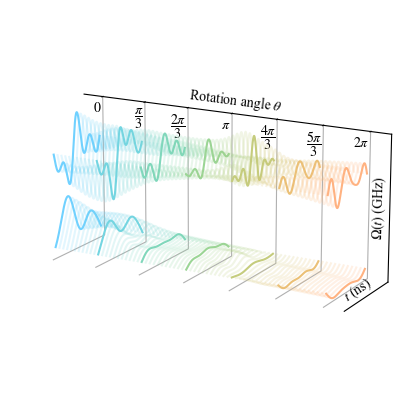

In [107]:
def plotPulses_XYcontrol(result, fig: Union[Figure, SubFigure], cmap=cm.brg):
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    x_list = result['x']
    tlist = result['tlist']
    LENGTH = len(x_list)
    numOfParams = 9

    hai2 = HaiTwoPulses(tlist, numOfParams)
    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)

    highlighted = set(np.linspace(0, LENGTH-1, 7, dtype=np.int32))

    for index in np.linspace(0, LENGTH-1, 67, dtype=np.int32):
        A = x_list[index]
        pulse_x, pulse_y = hai2.fromParams(A)
        pulse_x, pulse_y = np.real(pulse_x), np.real(pulse_y)
        angle_x = np.real(result['cost'][index])
        ax.plot(
            np.ones(tlist.shape) * angle_x, tlist, pulse_x,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
        ax.plot(
            np.ones(tlist.shape) * angle_x, tlist, pulse_y*1.5 - 2,
            color=cmap(colorNormalizer(angle_x)),
            alpha=1 if index in highlighted else 0.2
        )
    ax.set_box_aspect((3.5, 1, 1.5))
    ax.view_init(16, -61, 0)

    ax.set_xlabel('Rotation angle ' + r'$\theta$',
                  labelpad=-10)
    ax.xaxis._axinfo['juggled'] = (2,0,1)
    PI = np.pi
    xticks = [0, PI/3, 2*PI/3, 3*PI/3, 4*PI/3, 5*PI/3, 2*PI]
    xtickLabels = [
        s+'\n\n' for s in
        r'$0$ $\dfrac{\pi}{3}$ $\dfrac{2\pi}{3}$ $\pi$ $\dfrac{4\pi}{3}$ $\dfrac{5\pi}{3}$ $2\pi$'.split()
    ]
    ax.set_xticks(xticks, xtickLabels, ha='right')
    ax.tick_params(axis="x", pad=-12)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.set_ylabel(r'$t$ (ns)', labelpad=-25)
    yticks = [0, 25, 50]
    yticks = []
    ax.set_yticks(yticks)
    # ax.tick_params(axis="y", pad=-2)
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_zlabel(r'$\Omega(t)$ (GHz)', labelpad=-25)
    zticks = [-1, 0, .75]
    zticks = []
    ax.set_zticks(zticks)
    # ax.set_zlim(bottom=-1)
    # ax.zaxis.set_tick_params(labelright=True)
    # ax.zaxis.set_tick_params(va='center')
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    return

%matplotlib inline

fig = plt.figure(figsize=(10, 5), layout='constrained')

cmap = cc.cm.CET_I2
plotPulses_XYcontrol(result_Neg0to2PI, fig, cmap=cmap)
# fig.set_layout_engine('tight')
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig.tight_layout()
fig.savefig(r".\data\XYcontrolXYZnoise\pulses.pdf",
            bbox_inches=Bbox([[3.6, 1.37],  # [L, B]
                              [7.05, 3.65]]))  # [R, T]
fig.show()

#### 1.3.1.3. <a id='toc1_3_1_3_'></a>[Noisefid xyz](#toc0_)

In [4]:
with open(r'.\data\XYcontrolXYZnoise\XYZnoiseFid_data.pickle', mode='rb') as f:
    XYZnoiseFid_data = pickle.load(f)

Fidelity over $0.999$ for $\delta \in [-0.022, 0.026]$. Checked with coding.

In [37]:
xfid = np.real(XYZnoiseFid_data['fidUnderNoise']['X'])
delta = XYZnoiseFid_data['noisePercent']
dl, dr = [], []
for fids in xfid:
    idx = np.argmax(fids >= 0.999)
    dl.append(delta[idx])
    idx = len(delta) - 1 - np.argmax(fids[::-1] >= 0.999)
    dr.append(delta[idx])

np.max(dl), np.min(dr)

(-0.02200000000000002, 0.025999999999999995)

In [109]:
seq = 1

C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\4093085500.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_XnoiseFid.set_yticklabels(ax_XnoiseFid.get_yticklabels(), va='bottom')
C:\Users\neohu\AppData\Local\Temp\ipykernel_33936\4093085500.py:86: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


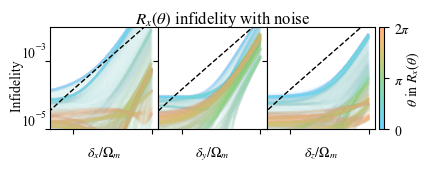

In [110]:
def plotNoiseFid_SingleNoise(
        XYZnoiseFid_data, opname: str, colorNormalizer,
        ax: Axes, _δm=0.1, cmap=cm.brg, xtick: bool=False
    ) -> None:
    # with open(r'.\data\XYcontrolXYZnoise\XYZnoiseFid_data.pickle', mode='rb') as f:
    #     XYZnoiseFid_data = pickle.load(f)

    needToShow = np.nonzero(np.logical_and(
        -_δm < XYZnoiseFid_data['noisePercent'], XYZnoiseFid_data['noisePercent'] < _δm
    ))[0]

    for k in range(0, len(XYZnoiseFid_data['angle'])):
        ax.loglog(
            XYZnoiseFid_data['noisePercent'][needToShow],
            1-XYZnoiseFid_data['fidUnderNoise'][opname][k][needToShow],
            c=cmap(colorNormalizer(XYZnoiseFid_data['angle'][k])),
            alpha=.02
        )
        ax.loglog(
            - XYZnoiseFid_data['noisePercent'][needToShow],
            1-XYZnoiseFid_data['fidUnderNoise'][opname][k][needToShow],
            c=cmap(colorNormalizer(XYZnoiseFid_data['angle'][k])),
            alpha=.02
        )

    # Plot baseline pulse: half sine
    noiseFid = np.load(f'./data/baseSine/noiseFid.npy')
    needToShow = np.nonzero(np.logical_and(
        -_δm < noiseFid[0], noiseFid[0] < _δm
    ))[0]
    ax.loglog(
        noiseFid[0][needToShow],
        1-noiseFid[1][needToShow],
        linestyle='dashed', color='black', linewidth=1
    )
    
    ax.set_xlabel(rf'$\delta_{opname.lower()}/\Omega_m$')
    # ax.set_ylim(bottom=1-1e-2, top=1+1e-5)
    # ax.set_ylabel('Fidelity')
    ax.set_xlim(left=5e-3)
    # ticks = [1e0, 1e1]
    # tickLabels = [0, 1]
    # ax.set_xticks(ticks, tickLabels)
    ax.minorticks_off()
    if not xtick:
        ax.set_xticklabels([])
    return

def plotNoiseFid_XYZnoise(
        XYZnoiseFid_data, fig: Union[Figure, SubFigure], _δm=0.1, cmap=cm.brg,
        wspace=0.0, cbarPad=0.2, xtick=False
    ) -> None:
    axesList: list[Axes] = fig.subplots(nrows=1, ncols=3, sharey=True)
    fig.subplots_adjust(wspace=wspace)
    ax_XnoiseFid, ax_YnoiseFid, ax_ZnoiseFid = axesList
    
    colorNormalizer = mpl.colors.Normalize(0, 2*np.pi)
    plotNoiseFid_SingleNoise(XYZnoiseFid_data, 'X', colorNormalizer, ax_XnoiseFid, cmap=cmap, _δm=_δm, xtick=xtick)
    plotNoiseFid_SingleNoise(XYZnoiseFid_data, 'Y', colorNormalizer, ax_YnoiseFid, cmap=cmap, _δm=_δm, xtick=xtick)
    plotNoiseFid_SingleNoise(XYZnoiseFid_data, 'Z', colorNormalizer, ax_ZnoiseFid, cmap=cmap, _δm=_δm, xtick=xtick)

    # ax_XnoiseFid.set_ylim(bottom=1-1e-2, top=1+1e-5)
    ax_XnoiseFid.set_ylim(bottom=1e-5, top=1e-2)
    ax_XnoiseFid.set_ylabel('Infidelity    ', labelpad=-2)
    ax_XnoiseFid.set_yticklabels(ax_XnoiseFid.get_yticklabels(), va='bottom')
    ax_XnoiseFid.tick_params(axis="y", pad=-1.5)
    cbar = fig.colorbar(cm.ScalarMappable(colorNormalizer, cmap=cmap), ax=axesList, pad=cbarPad)
    cbar.set_label(r'$\theta$ in $R_x(\theta)$', labelpad=-4)  # Set the label for the colorbar
    cbar.set_ticks([0, np.pi, 2*np.pi])  # Specify custom tick positions
    cbar.set_ticklabels('0 $\pi$ $2\pi$'.split())  # Set custom tick labels

    fig.suptitle(r'$R_x(\theta)$ infidelity with noise        ', y=1.)

    return

cmap = cc.cm.CET_I2

fig = plt.figure(figsize=(5, 1.5))
fig.subplots_adjust(bottom=0.2)
plotNoiseFid_XYZnoise(XYZnoiseFid_data, fig, cmap=cmap, cbarPad=0.01, xtick=False)
tightBox = fig.get_tightbbox()
fig.savefig(r".\data\XYcontrolXYZnoise\XYZnoiseFid.png", bbox_inches=tightBox, dpi=500)
# seq += 1
# fig.suptitle('semilogy infid ym=1e-5', y=1)
# fig.savefig(rf"H:\Neo\Study\SUSTech Physics\Projects\RIPV\paper\temp\XYZnoiseFid_{seq}.png", bbox_inches='tight')
fig.show()

## 1.4. <a id='toc1_4_'></a>[Orthogonality test](#toc0_)

In [70]:
nvec = 10000

dimvec = 7
randvecs = np.random.standard_normal((nvec, dimvec))
randvecs = np.random.random_sample((nvec, dimvec)) * 2 - 1
norms = np.linalg.norm(randvecs, axis=1, keepdims=True)
cos = randvecs @ randvecs.T / (norms @ norms.T) * np.logical_not(np.identity(nvec))
angles7d = np.arccos(cos)

dimvec = 10
randvecs = np.random.standard_normal((nvec, dimvec))
randvecs = np.random.random_sample((nvec, dimvec)) * 2 - 1
norms = np.linalg.norm(randvecs, axis=1, keepdims=True)
cos = randvecs @ randvecs.T / (norms @ norms.T) * np.logical_not(np.identity(nvec))
angles10d = np.arccos(cos)

dimvec = 100
randvecs = np.random.standard_normal((nvec, dimvec))
randvecs = np.random.random_sample((nvec, dimvec)) * 2 - 1
norms = np.linalg.norm(randvecs, axis=1, keepdims=True)
cos = randvecs @ randvecs.T / (norms @ norms.T) * np.logical_not(np.identity(nvec))
angles100d = np.arccos(cos)


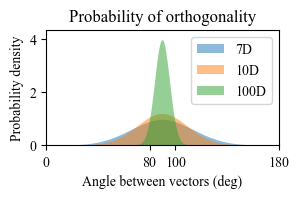

In [86]:
histtype = 'stepfilled'
plt.figure(figsize=(3, 1.5))
plt.hist(angles7d.flatten(), bins=2000, density=True, histtype=histtype, label='7D', alpha=.5)
plt.hist(angles10d.flatten(), bins=2000, density=True, histtype=histtype, label='10D', alpha=.5)
plt.hist(angles100d.flatten(), bins=2000, density=True, histtype=histtype, label='100D', alpha=.5)
plt.xlim(np.deg2rad([0, 180]))
plt.legend()
degs = [0, 80, 100, 180]
plt.xticks(np.deg2rad(degs), labels=[str(d) for d in degs])
plt.title('Probability of orthogonality')
plt.xlabel('Angle between vectors (deg)')
plt.ylabel('Probability density')
tightBox = plt.gcf().get_tightbbox()
plt.savefig('./data/orthogonality/prob_ortho.png', dpi=400, bbox_inches=tightBox)
plt.show()